In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
import random
import torch.backends.cudnn as cudnn
from tqdm.notebook import tqdm
from datasets import load_dataset



In [2]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [3]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 5
image_size = 28
timesteps = 1000

dim = 64
channels = 1

In [4]:
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

In [5]:
# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transform_fuc(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transform_fuc)#.remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

model = Unet(
    dim = dim,
    dim_mults = (1, 2, 4),
    channels = channels,
    flash_attn = False
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = image_size,
    timesteps = timesteps,    # number of steps
    objective = 'pred_noise',
).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [8]:
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
diffusion.load_state_dict(checkpoint['diffusion_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# for epoch in tqdm(range(num_epochs)):
#     for step, inputs in enumerate(tqdm(dataloader)):
#         optimizer.zero_grad()

#         training_images = inputs['pixel_values'].to(device)

#         loss = diffusion(training_images)

#         if step % 100 == 0:
#             print("Loss:", loss.item())
#         loss.backward()
#         optimizer.step()



In [87]:
# 모델의 상태를 저장
# checkpoint = {
#     'model_state_dict': model.state_dict(),
#     'diffusion_state_dict': diffusion.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }

# torch.save(checkpoint, 'model_checkpoint.pth')

## 1. Choose one From Real FashionMNIST

In [9]:
def sample_figures(num_samples, datasets):
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 1 * 3))
    for i, ax in enumerate(axes):
        ax.imshow(datasets[i].detach().squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')

    plt.show()

def sample_figure(dataset):
    fig, axes = plt.subplots(1, 1, figsize=(1 * 3, 1 * 3))
    ax = axes
    ax.imshow(dataset.detach().squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    plt.show()

0
7
5
7
9


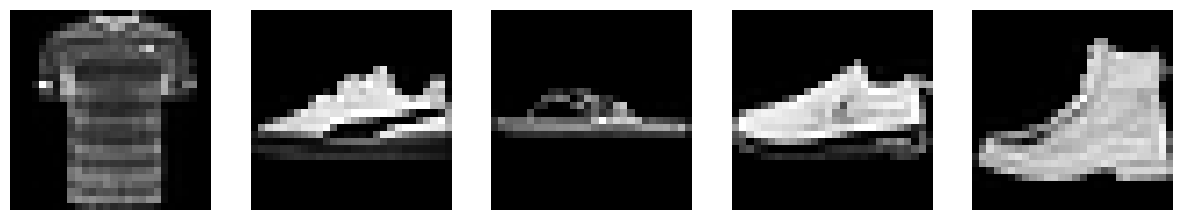

In [17]:
image_ind = 35
num_samples = 5
chosen_r_datasets = transformed_dataset['test'][image_ind: image_ind + num_samples]['pixel_values']
chosen_r_labels = transformed_dataset['test'][image_ind: image_ind + num_samples]['label']

fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 1 * 3))
ax = axes
for i, ax in enumerate(axes):
    print(chosen_r_labels[i])
    ax.imshow(chosen_r_datasets[i].detach().squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()


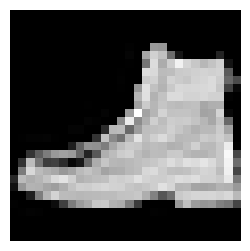

In [18]:
chosen_r_dataset = chosen_r_datasets[4]

sample_figure(dataset = chosen_r_dataset)

# num_samples = 1
# fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 1 * 3))
# ax = axes
# ax.imshow(chosen_r_dataset.detach().squeeze().cpu().numpy(), cmap='gray')
# ax.axis('off')
# plt.show()

## 2. Generate Image From Noise Z

In [38]:
batch_size = 50

sampled_images = diffusion.sample(batch_size = batch_size)
sampled_images.shape # (4, 3, 128, 128)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([50, 1, 28, 28])

## 3. Choose Generated Image similar with chosen from Real data, and regenerate

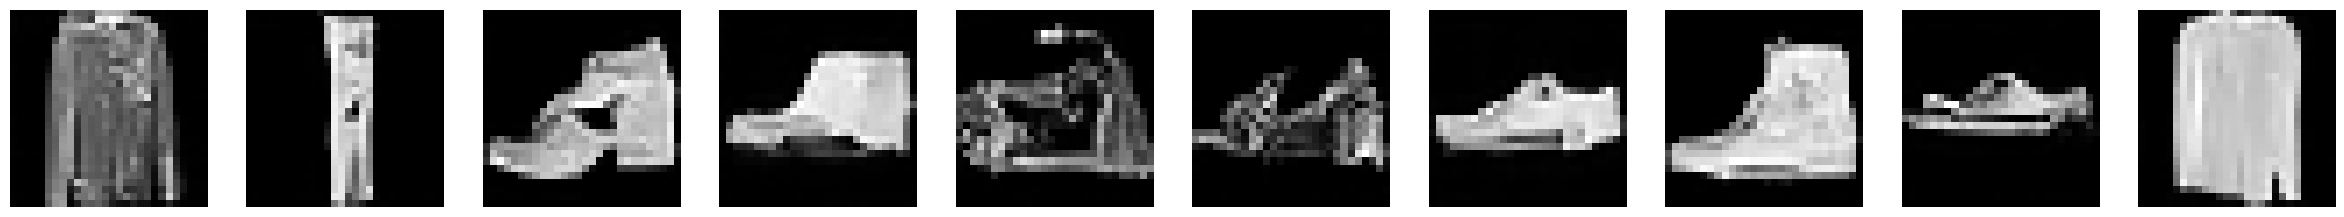

In [42]:
# batch_size만큼 생성

random_index = 30
num_samples = 10

chosen_gen_datasets = sampled_images[random_index:random_index + num_samples , :, :, :]

sample_figures(num_samples = num_samples, datasets = chosen_gen_datasets)


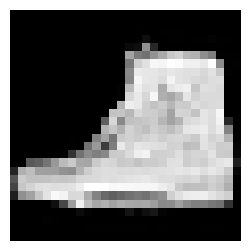

In [43]:
chosen_gen_dataset = chosen_gen_datasets[7] # 0 ~ 4 중 1개 선택
normalized_gen_img = chosen_gen_dataset.cpu().apply_(lambda x: (x * 2) - 1) # 만들어진 이미지 중 1개 


sample_figure(dataset = normalized_gen_img)


### 4. Regenerate until regenerate image from noise similar to chosen image

In [44]:
def get_noisy_image(diffusion, x_start, t): # 데이터에 q 연산
  # add noise
  x_noisy = diffusion.q_sample(x_start, t=t)

  return x_noisy

batch_size = 10

def regenerate_image(normalized_gen_img, t_num = 500, batch_size = 10): # q 연산 후 다시 p 연산
    x_start = normalized_gen_img.to(device)

    t = torch.tensor([t_num] * batch_size).to(device)

    x = get_noisy_image(diffusion, x_start, t)

    x_p = x.unsqueeze(dim = 1)
    x_start_p = x_start.unsqueeze(dim=1)
    # model_out = diffusion.model(x, t, None)
    for i in tqdm(reversed(range(t_num)), total = t_num):
        x_p, x_start_p = diffusion.p_sample(x_p, i)

    return x_start, x_p, x_start_p # 처음 이미지 x_{p-1}, 만들어진 이미지(batch개), 만들어진 이미지(batch개)

def compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p): # 왼쪽 : 유저 선택 이미지, 오른쪽 : 만들어진 이미지
    for idx in range(start_index, end_index):
        generated_index = idx

        real_gen_dataset = torch.cat((chosen_r_dataset.to(device), x_p[generated_index].to(device)), dim = 0)
        real_gen_dataset.size()

        num_samples = real_gen_dataset.size(0)

        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 1 * 3))

        for i, ax in enumerate(axes):
            ax.imshow(real_gen_dataset[i].detach().squeeze().cpu().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()

In [51]:
x_0, x_p0, _ = regenerate_image(normalized_gen_img, t_num = 200, batch_size = batch_size)

  0%|          | 0/200 [00:00<?, ?it/s]

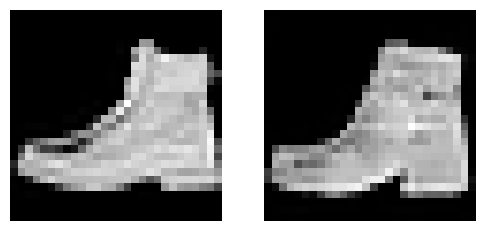

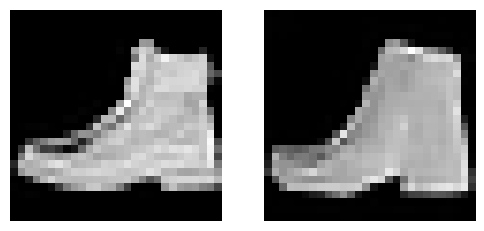

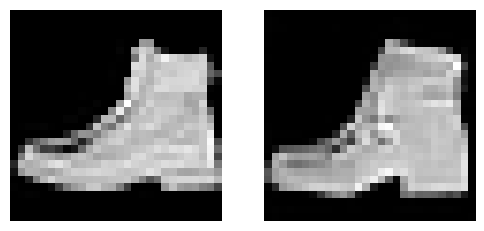

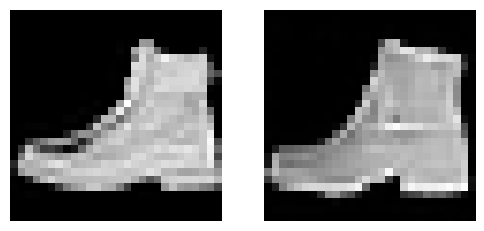

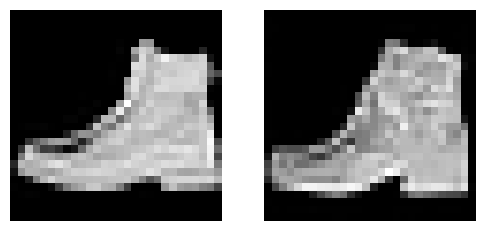

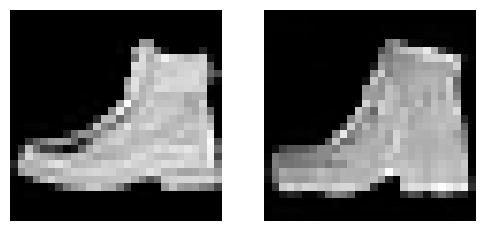

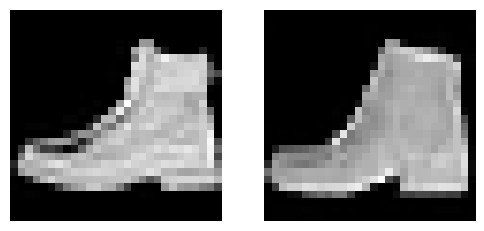

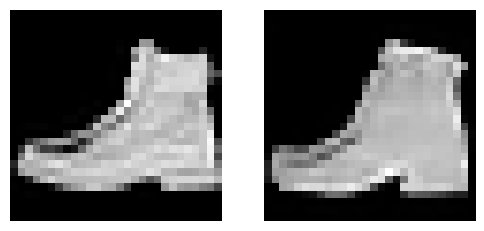

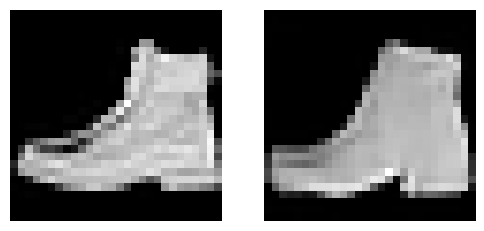

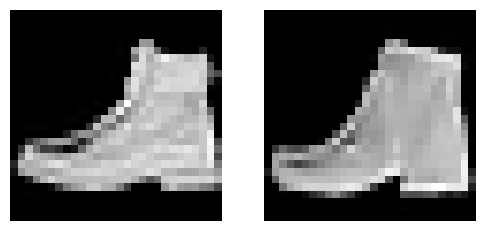

In [75]:
start_index = 0
num_samples = 10

end_index = start_index + num_samples

# 0단계부터 비교하고 싶은 단계 선택
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p0)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p1)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p2)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p3)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p4)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p5)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p6)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p7)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p8)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p9)
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p10)
compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p11) 
# compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p12)  


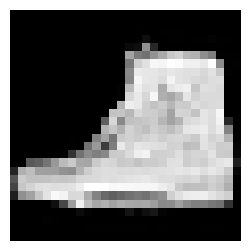

In [53]:
# 만들어진 이미지 중 유저가 선택한 이미지와 비슷한 이미지 (0단계)

sample_figure(dataset = x_0)
# num_samples = 1
# fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 1 * 3))
# ax = axes
# ax.imshow(x_start.detach().squeeze().cpu().numpy(), cmap='gray')
# ax.axis('off')
# plt.show()

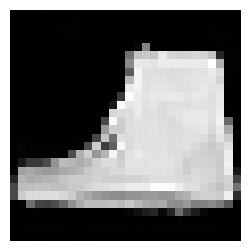

  0%|          | 0/200 [00:00<?, ?it/s]

In [54]:
# 1단계
x_1 = x_p0[9] #  x_t = x_p{t-1} 0~9 번 중 선택
# x_1 = x_0 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_1)

x_1, x_p1, _ = regenerate_image(x_1, t_num = 200, batch_size = batch_size) # t_num으로 횟수 조절

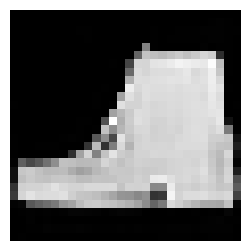

  0%|          | 0/200 [00:00<?, ?it/s]

In [56]:
# 2단계
x_2 = x_p1[3] #  x_t = x_p{t-1} 0~9 번 중 선택
# x_2 = x_1 #이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_2)

x_2, x_p2, _ = regenerate_image(x_2, t_num = 200, batch_size = batch_size)


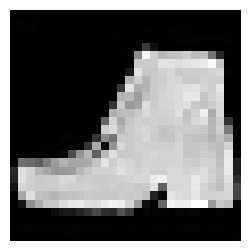

  0%|          | 0/200 [00:00<?, ?it/s]

In [58]:
# 3단계
x_3 = x_p2[7] #  x_t = x_p{t-1} 0~9 번 중 선택
# x_3 = x_2 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_3)


x_3, x_p3, _ = regenerate_image(x_3, t_num = 200, batch_size = batch_size)

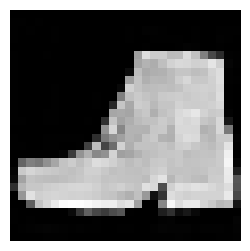

  0%|          | 0/200 [00:00<?, ?it/s]

In [60]:
# 4단계
x_4 = x_p3[1] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_4 = x_3 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_4)

x_4, x_p4, _ = regenerate_image(x_4, t_num = 200, batch_size = batch_size)

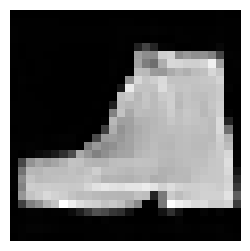

  0%|          | 0/200 [00:00<?, ?it/s]

In [62]:
# 5단계
x_5 = x_p4[0] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_5 = x_4 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_5)


x_5, x_p5, _ = regenerate_image(x_5, t_num = 200, batch_size = batch_size)

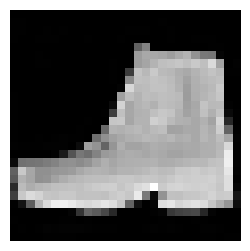

  0%|          | 0/200 [00:00<?, ?it/s]

In [64]:
# 6단계
x_6 = x_p5[8] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_6 = x_5 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_6)

x_6, x_p6, _ = regenerate_image(x_6, t_num = 200, batch_size = batch_size)

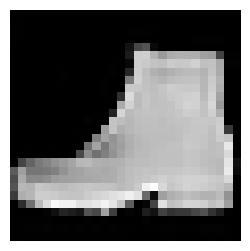

  0%|          | 0/200 [00:00<?, ?it/s]

In [66]:
# 7단계
x_7 = x_p6[5] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_7 = x_6 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_7)

x_7, x_p7, _ = regenerate_image(x_7, t_num = 200, batch_size = batch_size)

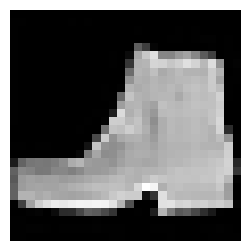

  0%|          | 0/200 [00:00<?, ?it/s]

In [68]:
# 8단계
x_8 = x_p7[7] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_8 = x_7 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_8)

x_8, x_p8, _ = regenerate_image(x_8, t_num = 200, batch_size = batch_size)

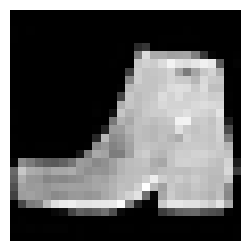

  0%|          | 0/200 [00:00<?, ?it/s]

In [70]:
# 9단계
x_9 = x_p8[9] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_9 = x_8 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_9)

x_9, x_p9, _ = regenerate_image(x_9, t_num = 200, batch_size = batch_size)

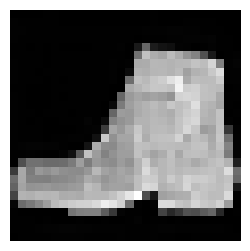

  0%|          | 0/200 [00:00<?, ?it/s]

In [72]:
# 10단계
x_10 = x_p9[0] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_10 = x_9 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_10)

x_10, x_p10, _ = regenerate_image(x_10, t_num = 200, batch_size = batch_size)

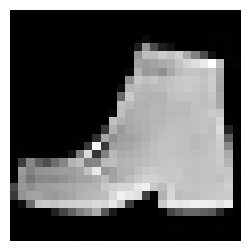

  0%|          | 0/200 [00:00<?, ?it/s]

In [74]:
# 11단계
x_11 = x_p10[6] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_11 = x_10 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_11)

x_11, x_p11, _ = regenerate_image(x_11, t_num = 200, batch_size = batch_size)

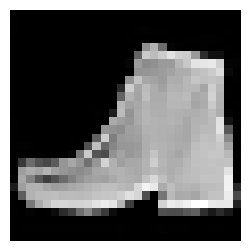

  0%|          | 0/200 [00:00<?, ?it/s]

In [76]:
# 12단계
x_12 = x_p11[9] #  x_t = x_p{t-1} 0~9 번 중 선택, 이전꺼 쓰고 싶으면 x_{t-1}
# x_12 = x_11 이전꺼 쓰고 싶으면 x_{t-1}

sample_figure(dataset = x_12)

x_12, x_p12, _ = regenerate_image(x_12, t_num = 200, batch_size = batch_size)

In [93]:
# DAE에 사용할 이미지 선택
normalized_gen_img = x_p12[6]

## 5. denoise with DAE

In [77]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 5

In [78]:
mnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
# mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [79]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
# dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [81]:
class DAE_CNN(nn.Module):
    def __init__(self, c, latent_dim):
        super(DAE_CNN,self).__init__()

        self.c = c
        encoder_layers = []
        decoder_layers = []

        encoder_layers.append(nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=4, stride=2, padding=1))
        # encoder_layers.append(nn.Dropout(p=0.2)),
        encoder_layers.append(nn.ReLU())
        
        encoder_layers.append(nn.Conv2d(in_channels=self.c, out_channels=self.c * 2, kernel_size=4, stride=2, padding=1))
        encoder_layers.append(nn.ReLU())

        self.encoder = nn.Sequential(*encoder_layers)

        self.encoder_fc = nn.Linear(self.c * 2 * 7 * 7, latent_dim)



        # self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        # self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, self.c * 2 * 7 * 7)
        
        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1))
        # decoder_layers.append(nn.Dropout(p=0.2))
        decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1))
        # decoder_layers.append(nn.Dropout(p=0.2))
        decoder_layers.append(nn.Sigmoid())

        # decoder_layers.append(nn.Linear(latent_dim, hidden_dim))
        # decoder_layers.append(nn.ReLU())


        # for i in range(layer_num - 1, 0 ,-1):
        #     decoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
        #     decoder_layers.append(nn.ReLU())


        self.decoder = nn.Sequential(*decoder_layers)
                

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        z = self.encoder(x)
        z = z.view(z.size(0), -1)
        encoder_output = self.encoder_fc(z)
        
        z = self.decoder_fc(encoder_output)
        z = z.view(z.size(0), self.c * 2, 7, 7)
        out = self.decoder(z)
        return encoder_output, out


In [82]:
# layer_num = 3 # 6
# hidden_dim = 512 # 512
c = 64
latent_dim = 64 # 10

dae = DAE_CNN(c, latent_dim).to(device)
dae_optimizer = torch.optim.Adam(dae.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

In [83]:
checkpoint = torch.load('DAE_CNN_checkpoint.pth')
dae.load_state_dict(checkpoint['model_state_dict'])
dae_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [27]:
# # 모델의 상태를 저장
# checkpoint = {
#     'model_state_dict': best_model_high.state_dict(),
#     # 'diffusion_state_dict': diffusion.state_dict(),
#     'optimizer_state_dict': dae_optimizer.state_dict(),
# }

# torch.save(checkpoint, 'DAE_CNN_checkpoint.pth')

In [84]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.1 # 0.05
    noisy_img = img + noise
    return noisy_img

In [85]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_train_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noisy_x = add_noise(inputs).to(device)
                inputs = inputs.to(device)                                       # transfer inputs to GPU 
                y = inputs.view(-1, 1, 28, 28).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    z, out = model(noisy_x)
                    loss = criterion(out, y)  # calculate a loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            # if phase == 'val':
            #     val_loss_history.append(epoch_loss)

            if phase == 'train' and epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [23]:
# DAE 모델 학습 코드

# best_model_high, train_loss_history_high, val_loss_history_high = train_model(dae, dataloaders, criterion, dae_optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.0023

Epoch 1/4
----------
train Loss: 0.0021

Epoch 2/4
----------
train Loss: 0.0021

Epoch 3/4
----------
train Loss: 0.0021

Epoch 4/4
----------
train Loss: 0.0020

Training complete in 0m 56s


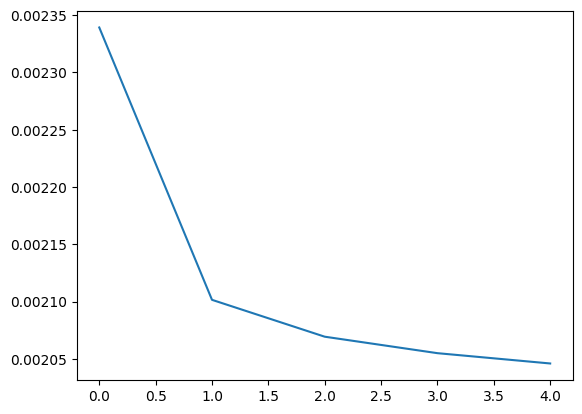

In [24]:
# # Let's draw a learning curve for low and high capacity models.
# # plt.plot(train_loss_history, label='low_train')
# # plt.plot(val_loss_history, label='low_val')
# plt.plot(train_loss_history_high, label='high_train')
# # plt.plot(val_loss_history_high, label='high_val')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [86]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        noisy_x = add_noise(inputs).to(device)
        inputs = inputs.to(device)                                       # transfer inputs to GPU 
        y = inputs.view(-1, 1, 28, 28).to(device)

        z, out = dae(noisy_x)
        test_loss = criterion(out, y)  # calculate a loss
        
        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.0020802991792559624


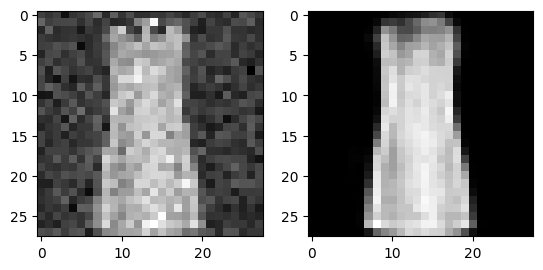

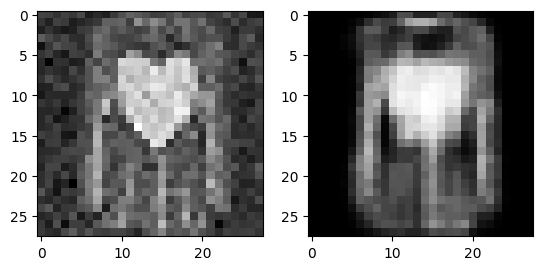

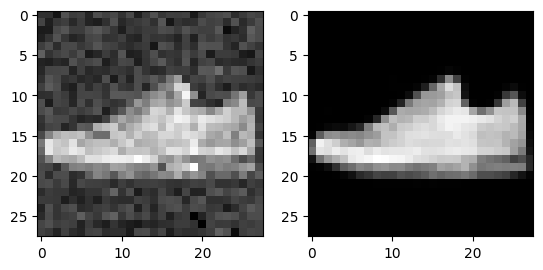

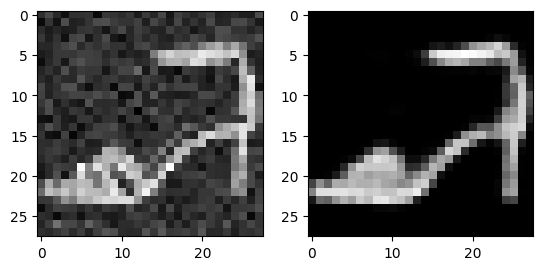

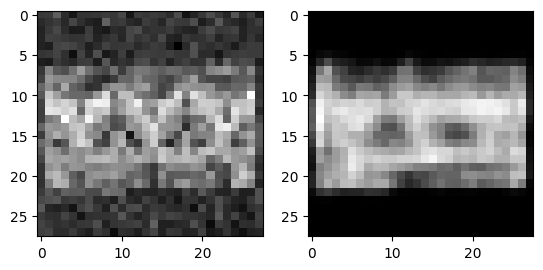

In [87]:
out_img_high = torch.squeeze(out.cpu().data) # out_img_high
# print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noisy_x[i]).cpu().numpy(),cmap='gray')
    # plt.subplot(1,3,2)
    # plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img_high[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()

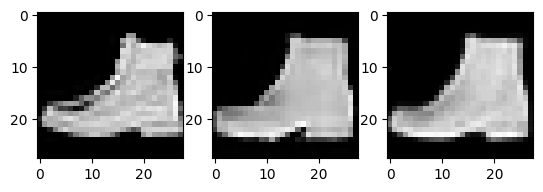

In [89]:
x_list = [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12]

x_img = x_7
# for x_img in x_list:
gen_img = x_img.to('cpu').apply_(lambda x: (x + 1) / 2).unsqueeze(dim = 1) # [-1, 1] -> [0, 1]
# noisy_x = add_noise(gen_img).to(device)
                    #   transfer inputs to GPU 
# y = inputs.view(-1, 28*28).to(device)
# print(gen_img.size())

noisy_x = gen_img.to(device)
z, out = dae(noisy_x)


plt.subplot(1,3,1)
plt.imshow(torch.squeeze(chosen_r_dataset).detach().cpu().numpy().reshape(28, 28),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(torch.squeeze(noisy_x).cpu().numpy(),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(torch.squeeze(out).detach().cpu().numpy().reshape(28, 28),cmap='gray')
plt.show()

### Result

In [91]:
def result_figure(chosen_r_dataset, normalized_gen_img, out):
    plt.subplot(1,3,1)
    plt.imshow(chosen_r_dataset.detach().squeeze().cpu().numpy(), cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(normalized_gen_img.detach().squeeze().cpu().numpy(), cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(out).detach().cpu().numpy().reshape(28, 28),cmap='gray')

    plt.show()

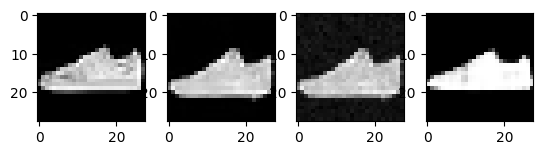

In [539]:
# label 7


plt.subplot(1,4,1)
plt.imshow(chosen_r_dataset.detach().squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1,4,2)
plt.imshow(normalized_gen_img.detach().squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1,4,3)
plt.imshow(torch.squeeze(noisy_x).cpu().numpy(),cmap='gray')
plt.subplot(1,4,4)
plt.imshow(torch.squeeze(out).detach().cpu().numpy().reshape(28, 28),cmap='gray')


# plt.subplot(1,3,2)
# plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')

plt.show()

In [ ]:
# label 9


plt.subplot(1,4,1)
plt.imshow(chosen_r_dataset.detach().squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1,4,2)
plt.imshow(normalized_gen_img.detach().squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1,4,3)
plt.imshow(torch.squeeze(noisy_x).cpu().numpy(),cmap='gray')
plt.subplot(1,4,4)
plt.imshow(torch.squeeze(out).detach().cpu().numpy().reshape(28, 28),cmap='gray')


# plt.subplot(1,3,2)
# plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')

plt.show()

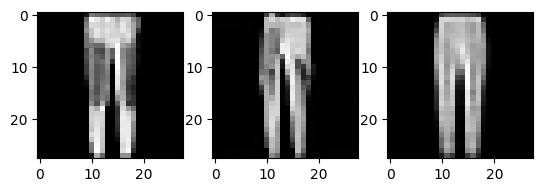

In [115]:
# label 1
result_figure(chosen_r_dataset, normalized_gen_img, out)

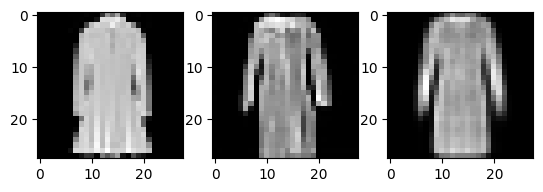

In [107]:
# label 3
result_figure(chosen_r_dataset, normalized_gen_img, out)

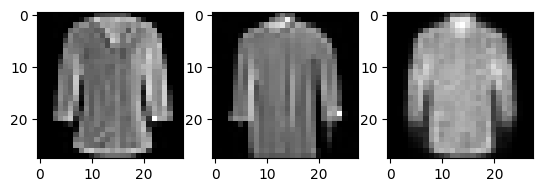

In [185]:
#label 6
result_figure(chosen_r_dataset, x_img, out)

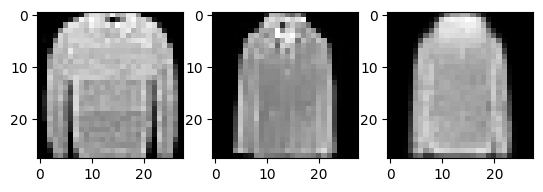

In [127]:
#label 2
result_figure(chosen_r_dataset, x_img, out)

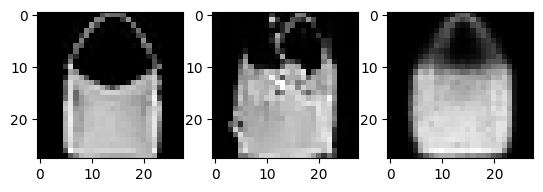

In [191]:
#label 8
result_figure(chosen_r_dataset, x_img, out)

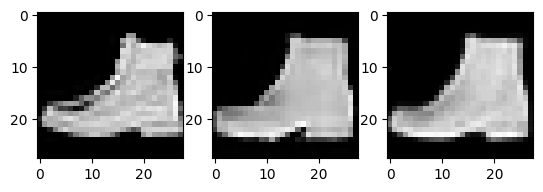

In [92]:
#label 9
result_figure(chosen_r_dataset, x_img, out)

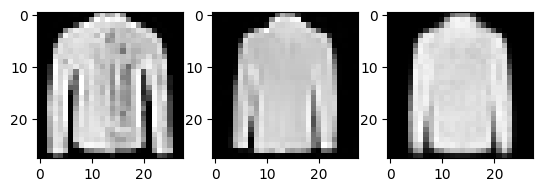

In [421]:
#label 4
result_figure(chosen_r_dataset, x_img, out)

### 6. Find near top10 Item

In [93]:
denoised_img = out
denoised_img_z = z
denoised_img_z.size()

torch.Size([1, 64])

In [94]:
mnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

dataloaders['train'] = DataLoader(mnist_train, batch_size=1, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=1, shuffle=False)

In [96]:
similarity_list = []
real_image_list = []


with torch.no_grad():
    running_loss = 0.0
    for inputs, label in tqdm(dataloaders["train"]):
        if label == 9:
            noisy_x = add_noise(inputs).to(device)
            inputs = inputs.to(device)                                       # transfer inputs to GPU 

            z, out = dae(noisy_x)
            real_image_list.append(inputs.cpu())
            
            cosine_sim = F.cosine_similarity(denoised_img_z, z, dim=1)
            similarity_list.append(cosine_sim.item())

stacked_out = torch.cat(real_image_list, dim = 0)
print(stacked_out.size())

  0%|          | 0/60000 [00:00<?, ?it/s]

torch.Size([6000, 1, 28, 28])


In [97]:
import heapq

def top_n_indexes(arr, n):
    min_heap = [(value, index) for index, value in enumerate(arr[:n])]
    heapq.heapify(min_heap)

    for i, value in enumerate(arr[n:], start=n):
        if value > min_heap[0][0]:
            heapq.heappop(min_heap)
            heapq.heappush(min_heap, (value, i))

    top_n_indexes = [index for (_, index) in sorted(min_heap, reverse=True)]
    return top_n_indexes

In [98]:
top_10_indexes = top_n_indexes(similarity_list, 10)

out_top10_list = stacked_out[top_10_indexes]

In [99]:
out_top10_list.size()

torch.Size([10, 1, 28, 28])

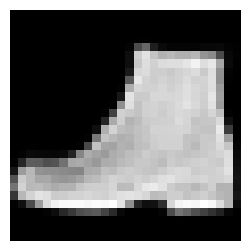

In [100]:
sample_figure(denoised_img)

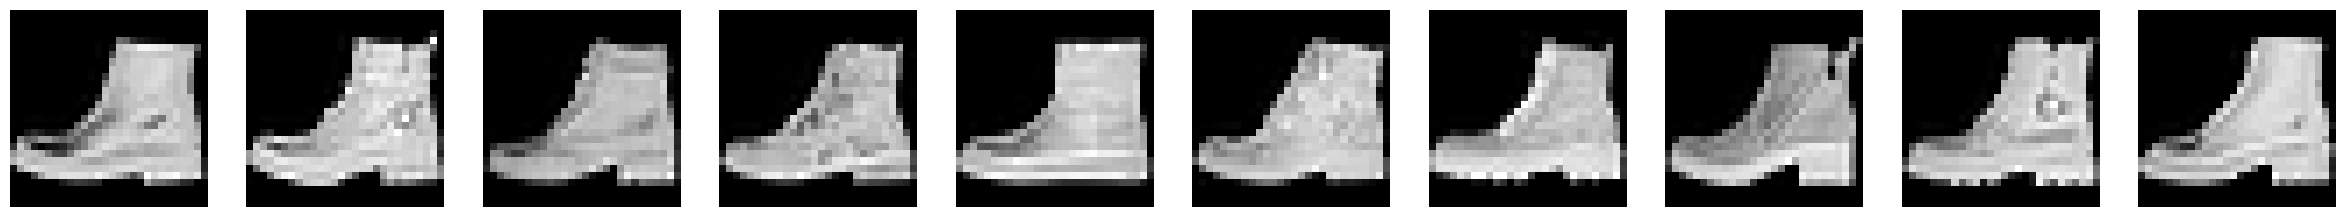

In [101]:
sample_figures(10, out_top10_list)